====================================================================================================================================
# SENSITIVITY
====================================================================================================================================

The "standard" is 2015 with 60 days, 1 degree resolution. Here I want to compare:
- ice vs no ice
- different resolutions
- summer vs winter
- differerent ice extents


In [1]:

import numpy as np
import matplotlib.pylab as plt
import glob
from datetime import datetime, timedelta
import sys
import xarray as xr
from matplotlib import rc
import matplotlib.animation as animation
import matplotlib as mpl
import cartopy.crs as ccrs
import os
import cartopy
from scipy.sparse import csr_matrix, load_npz, save_npz
import scipy.sparse.linalg as sla
import cmocean


from timeit import default_timer as timer



'/scratch/AnnekeV/output/single_particles/bering-everyday-05-09_npart_1095_start_2009-02-01_simdays_2800_kernel_AdvectionRK4_ocean_dtdays_1shifted.nc'

In [4]:
sys.path.insert(0,'.')    # '.' is in the same folder
%load_ext autoreload
%autoreload 1
#  Reload all modules imported with %aimport every time before executing the Python code typed.

# %cd /home/students/6252699/thesis/parcels2/
%aimport advect_ice
%aimport plot_functions
%aimport transition_matrices

%matplotlib inline

import functions.lay_out
plt.style.use(['default'])


In [5]:
import matplotlib as mpl
plt.style.use(['default'])

################################################################

# plotting parameters
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams["figure.figsize"] = [8 , 4]
mpl.rcParams['legend.fontsize'] = 12      #legend size
#title params
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['font.style'] = 'italic'    #all fonts italic
#axes params
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams["xtick.labelsize"] = 13
mpl.rcParams["ytick.labelsize"] = 13
# line width and grid
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams["axes.grid"] = 1
# mpl.rcParams["figure.subplot.left"] = 0.05
# mpl.rcParams["figure.subplot.right"] = 0.1
# mpl.rcParams["figure.subplot.bottom"] = 0.11
mpl.rcParams["savefig.bbox"] = 'tight'
mpl.rcParams["savefig.pad_inches"] = 0.1
mpl.rcParams['legend.loc'] =  'best'

# colors
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR


## functions 
============================================================================================================

In [6]:
def times_calc(timespan, simdays):
    return int(timespan/simdays +1)



def load_transition_matrices(days, res, year = 0, original = True, custom = ""): 
    '''
    Loads the transition matrices from the file, based on simulation lenght, resolution and year. Default is combined years
    If original, no sensititivity
    '''

    lonbins = np.load(out_dir + "lonbins_" + "res_{}.npy".format(int(res)))
    latbins = np.load(out_dir + "latbins_" + "res_{}.npy".format(int(res)))
    
    if original:
    
        if year == 0:
            M = load_npz(out_dir + "M" + "_added_years_" + "simdays_{}_res_{}.npz".format(days, res))
            T = np.load(out_dir  + "T" + "_added_years_" + "simdays_{}_res_{}.npy".format(days, res))
        else: 
            M = load_npz(out_dir + "M" + "_year_{}_simdays_{}_res_{}.npz".format(year, days, res))
            T = np.load(out_dir  + "T" + "_year_{}_simdays_{}_res_{}.npy".format(year, days, res))
    else: 
        M = load_npz(out_dir + "sensitivity/M" + "_year_{}_simdays_{}_res_{}_{}.npz".format(year, days, res, custom))
        T = np.load(out_dir  + "sensitivity/T" + "_year_{}_simdays_{}_res_{}_{}.npy".format(year, days, res, custom))
        
    
    return T, M, lonbins, latbins

def calculate_and_save_trans(filenames, res, custom, days=60, year=2015):
    '''Calculate and save the transition matrix
    custom is the name for the file'''
    T, latbins, lonbins, M = transition_matrices.trans_mat_digit_mf(filenames, res=res, final_index =-1, in_ice = False, void = True)
    print("Saving...")
    np.save(out_dir + "sensitivity/"  + "T" + "_year_{}_simdays_{}_res_{}_{}".format(year, days, res, custom), T)
    # np.save(out_dir + "sensitivity/"  + "lonbins_" + "res_{}".format(res), lonbins)
    # np.save(out_dir + "sensitivity/"  + "latbins_" + "res_{}".format(res), latbins)
    save_npz(out_dir + "sensitivity/" + "M" + "_year_{}_simdays_{}_res_{}_{}".format(year,days, res, custom), M)
    print(out_dir + "sensitivity/" + "M" + "_year_{}_simdays_{}_res_{}_{}".format(year,days, res, custom))
    print("Done")



In [22]:
def make_plot(M,lonbins,latbins, season, res, extent, kernel, timespan, simdays, strait, year,  add_cbar, save_it = False,returnstuff = False):
    start = timer()

    vmax     = 10
    vmin     = 1e-6
    ax_width = 7
    add_cbar = False
    r,c      = transition_matrices.grid_subplots(1)   #nr of rows (r) and columns (c) in the grid
    times    = times_calc(timespan, simdays)

    '''Initialize figure'''
    count    = 0
    fig      = plt.figure(figsize = [c*ax_width, r*ax_width])
    count   +=1
    print("{}_everywhere_res_{}_extent_{}_kernel_{}".format(season, int(res*10), extent, kernel))

    '''Set up axes'''
    ax = fig.add_subplot(r, c, count, projection=ccrs.NorthPolarStereo())
    ax = transition_matrices.set_subaxes(ax) 
    ax.add_feature(cartopy.feature.LAND, facecolor = (0,0,0,.1), edgecolor = (0,0,0,0.3), zorder = 1)

    '''Calculate and Plot the final distribution'''
    R_full                  = transition_matrices.final_R(M,latbins, lonbins, days = simdays, times=times, strait = strait, year=year)
    R                       = R_full[-1,:]
    nlat, nlon              = len(latbins)-1,len(lonbins)-1 
    ncels                   = nlat*nlon
    p                       = ax.pcolormesh(lonbins, latbins, R[0:ncels].reshape(nlat,nlon), norm = mpl.colors.LogNorm(vmin = vmin, vmax = vmax), cmap = 'viridis', transform = ccrs.PlateCarree())

    '''Extent'''
    extentdate = datetime.strptime("{}-03-01".format(2015), "%Y-%m-%d").date()
    plot_functions.plot_extent_contour(extentdate, ax, cmap = 'autumn')
    ax.set_title("")  
    plot_functions.set_circular_boundary(ax)

    if add_cbar: 
        print("hello")
        bottom_subplot = 0.10 / r
        fig.subplots_adjust(bottom = bottom_subplot)
        cbar_ax = fig.add_axes([0.15, 0.06, 0.7, bottom_subplot*.3])   #left, bottom, width , height
        cbar = fig.colorbar(p, cax=cbar_ax, orientation = 'horizontal', extend = 'max')

    if save_it: plt.savefig(fig_dir + "sensitivity/{}_everywhere_res_{}_extent_{}_kernel_{}.png".format(season, int(res*10), extent, kernel), bbox_inches="tight", pad_inches=0.1)
    print("{:.1f} s".format(timer()-start))
    
    if returnstuff: 
        return R

## main
============================================================================================================

In [8]:
data_dir_original = "/scratch/AnnekeV/output/11-4-combination-two-runs/"
out_dir           = "/scratch/AnnekeV/transition_matrices/"
fig_dir           = "/home/students/6252699/thesis/parcels2/figures/"
run_dir           = "/scratch/AnnekeV/output/sensitivity/"

## save matrices

In [9]:
glob.glob("/scratch/AnnekeV/output/sensitivity/*")

['/scratch/AnnekeV/output/sensitivity/04-05_npart_488371_start_2015-02-01_simdays_60__extent_5_kernel_AdvectionRK4_prob.nc',
 '/scratch/AnnekeV/output/sensitivity/04-05_npart_488371_start_2015-02-01_simdays_60__extent_30_kernel_AdvectionRK4_prob.nc',
 '/scratch/AnnekeV/output/sensitivity/nr2-04-05_npart_487788_start_2015-02-01_simdays_60__extent_5_kernel_AdvectionRK4_prob.nc',
 '/scratch/AnnekeV/output/sensitivity/04-05_npart_488374_start_2015-08-01_simdays_60__extent_15_kernel_AdvectionRK4_prob.nc',
 '/scratch/AnnekeV/output/sensitivity/nr2-04-05_npart_487792_start_2015-08-01_simdays_60__extent_15_kernel_AdvectionRK4_prob.nc',
 '/scratch/AnnekeV/output/sensitivity/nr2-04-05_npart_487788_start_2015-02-01_simdays_60__extent_95_kernel_AdvectionRK4_prob.nc',
 '/scratch/AnnekeV/output/sensitivity/nr2-04-05_npart_487788_start_2015-02-01_simdays_60__extent_60_kernel_AdvectionRK4_prob.nc',
 '/scratch/AnnekeV/output/sensitivity/04-05_npart_488371_start_2015-02-01_simdays_60__extent_95_kernel_A

In [ ]:
'''
extent5 = glob.glob(run_dir + "*extent_5*")
print extent5
calculate_and_save_trans(extent5, res=1.0, custom="extent5")

extent30 = glob.glob(run_dir + "*extent_30*")
print extent30
calculate_and_save_trans(extent30, res=1.0, custom="extent30")

extent60 = glob.glob(run_dir + "*extent_60*")
print extent60
calculate_and_save_trans(extent60, res=1.0, custom="extent60")

extent95 = glob.glob(run_dir + "*extent_95*")
print extent95
calculate_and_save_trans(extent95, res=1.0, custom="extent95")
'''

In [124]:
'''summer = glob.glob(run_dir + "*2015-08-01*")
print summer
calculate_and_save_trans(summer, res=1.0, custom="summer")'''

['/scratch/AnnekeV/output/sensitivity/04-05_npart_488374_start_2015-08-01_simdays_60__extent_15_kernel_AdvectionRK4_prob.nc', '/scratch/AnnekeV/output/sensitivity/nr2-04-05_npart_487792_start_2015-08-01_simdays_60__extent_15_kernel_AdvectionRK4_prob.nc']
Opened dataset
Opened dataset
Made transition matrix
Count removal for sinks is 1
Done with T
Saving...
/scratch/AnnekeV/transition_matrices/sensitivity/M_year_2015_simdays_60_res_1.0_summer
Done


In [ ]:
oceans = glob.glob("/scratch/AnnekeV/output/sensitivity/*ocean*")
print oceans

custom    = "ocean"
res       = 1.
calculate_and_save_trans(ocens, res, custom)

## original and different resolution

In [10]:
res           = 1
year          = 2015
simdays       = 60
ts_everywhere = 2400
season        = "winter"
extent        = 15
kernel        = "ice"



findfile = sorted(glob.glob(data_dir_original+ "combined/*simdays_{}_*{}*".format(simdays,year)))[0]

In [11]:
findfile

'/scratch/AnnekeV/output/11-4-combination-two-runs/combined/04-11_million-particles_simdays_60_start_2015-02-01_kernel_AdvectionRK4prob.nc'

winter_everywhere_res_20_extent_15_kernel_ice

1.5 s
winter_everywhere_res_10_extent_15_kernel_ice

5.9 s
winter_everywhere_res_50_extent_15_kernel_ice

32.5 s


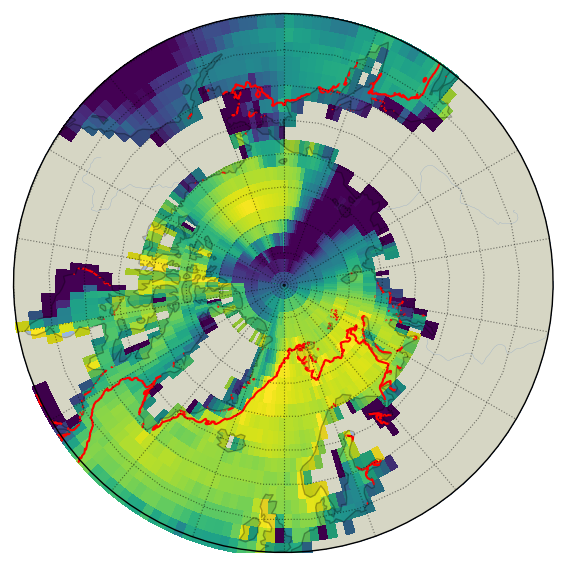

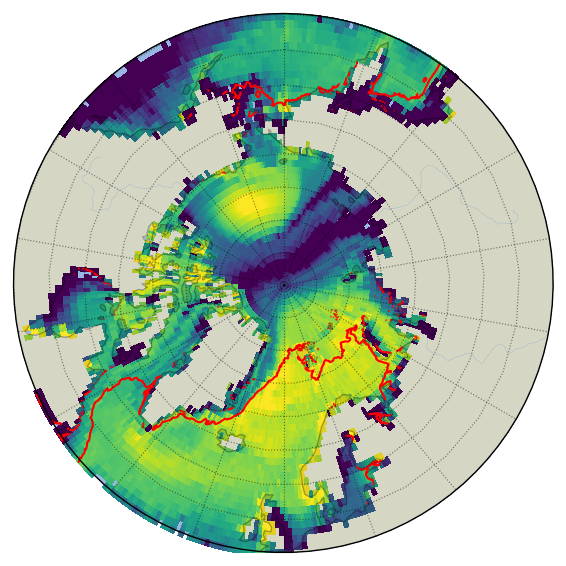

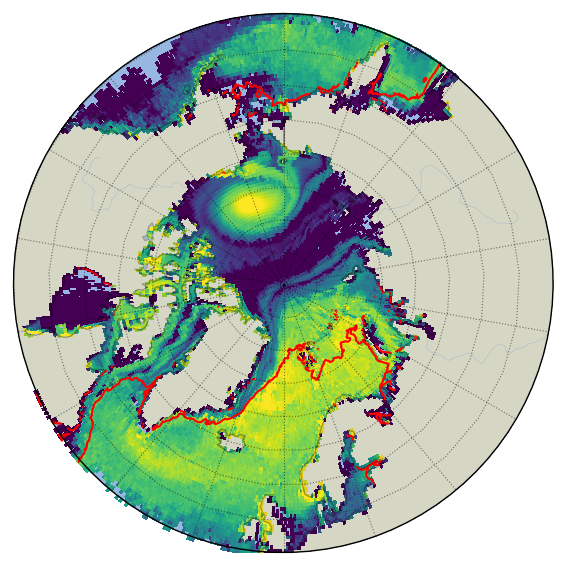

In [227]:

ax_width = 7
add_cbar = False


start = timer()

for res in [2, 1, 5]:


    vmax  = 10
    vmin  = 1e-6


    '''Make sure the grid looks nice''' 
    r,c = transition_matrices.grid_subplots(1)   #nr of rows (r) and columns (c) in the grid

    '''Initialize figure'''
    count = 0
    fig   = plt.figure(figsize = [c*ax_width, r*ax_width])
    fig.suptitle("")


    count+=1
    print("{}_everywhere_res_{}_extent_{}_kernel_{}".format(season, int(res*10), extent, kernel))

    times = times_calc(ts_everywhere, simdays)


    '''Set up axes'''
    ax = fig.add_subplot(r, c, count, projection=ccrs.NorthPolarStereo())
    ax = transition_matrices.set_subaxes(ax) 
    ax.add_feature(cartopy.feature.LAND, facecolor = (0,0,0,.1), edgecolor = (0,0,0,0.3), zorder = 1)

    '''Calculate and Plot the final distribution'''
#             T, latbins, lonbins, M = trans_mat_digit_mf(filename, res=res, final_index =-1, in_ice = False, void = True)
    T, M, lonbins, latbins = load_transition_matrices(days=simdays, res=res, year=year)

    R_full  = transition_matrices.final_R(M,latbins, lonbins, days = simdays, times=times, strait = strait, year=year)
    R       = R_full[-1,:]
    nlat, nlon = len(latbins)-1,len(lonbins)-1 
    ncels   = nlat*nlon
    p       = ax.pcolormesh(lonbins, latbins, R[0:ncels].reshape(nlat,nlon),   
                             norm = mpl.colors.LogNorm(vmin = vmin, vmax = vmax), 
                             cmap = 'viridis',
                             transform = ccrs.PlateCarree())

    '''Extent'''
    extentdate = datetime.strptime("{}-03-01".format(2015), "%Y-%m-%d").date()
    plot_functions.plot_extent_contour(extentdate, ax, cmap = 'autumn')
    ax.set_title("")  
    plot_functions.set_circular_boundary(ax)

    print("{:.1f} s".format(timer()-start))



    if add_cbar: 
        bottom_subplot = 0.10 / r
        fig.subplots_adjust(bottom = bottom_subplot)
        cbar_ax = fig.add_axes([0.15, 0.06, 0.7, bottom_subplot*.3])   #left, bottom, width , height
        cbar = fig.colorbar(p, cax=cbar_ax, orientation = 'horizontal', extend = 'max')

    plt.savefig(fig_dir + "sensitivity/{}_everywhere_res_{}_extent_{}_kernel_{}.png".format(season, int(res*10), extent, kernel), bbox_inches="tight", pad_inches=0.1)




## oceans

winter_everywhere_res_10_extent_15_kernel_ocean

hello
hello
1.4 s


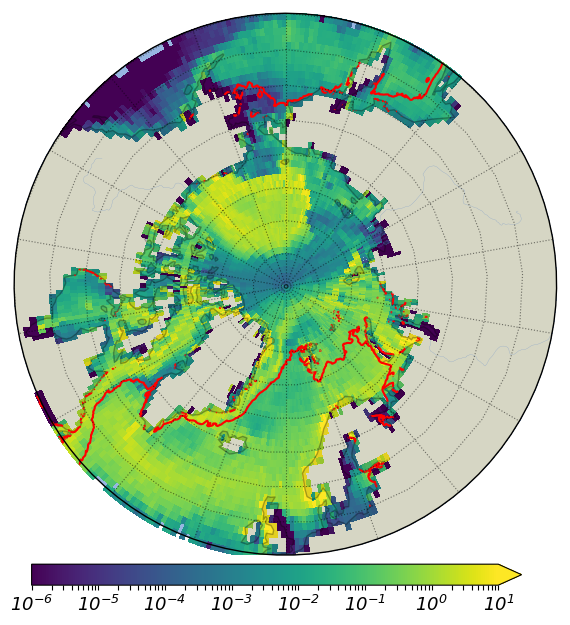

In [21]:
res           = 1.0
year          = 2015
simdays       = 60
ts_everywhere = 2400
season        = "winter"
extent        = 15
kernel        = "ocean"
strait        = "Everywhere"
custom        = "ocean"



# T, M, lonbins, latbins  = load_transition_matrices(days=60, res=1.0, year = 2015, original = False, custom = custom)
make_plot1(M,lonbins,latbins, season, res, extent, kernel, ts_everywhere, simdays, strait, year, add_cbar=True, save_it = False)


## SUMMER

summer_everywhere_res_10_extent_15_kernel_ice

3.0 s


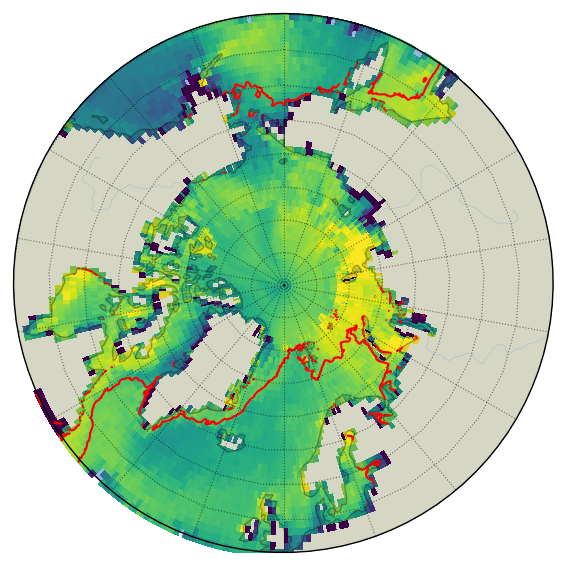

In [229]:
res           = 1.0
year          = 2015
simdays       = 60
ts_everywhere = 2400
season        = "summer"
extent        = 15
kernel        = "ice"
strait        = "Everywhere"
custom        = "summer"

T, M, lonbins, latbins  = load_transition_matrices(days=60, res=1.0, year = 2015, original = False, custom = custom)
make_plot(M,lonbins,latbins, season, res, extent, kernel, ts_everywhere, simdays, strait, year, save_it = True, add_cbar= False)



## DIFFERENT EXTENTS

(14401, 14401)
winter_everywhere_res_10_extent_5_kernel_ice

2.9 s


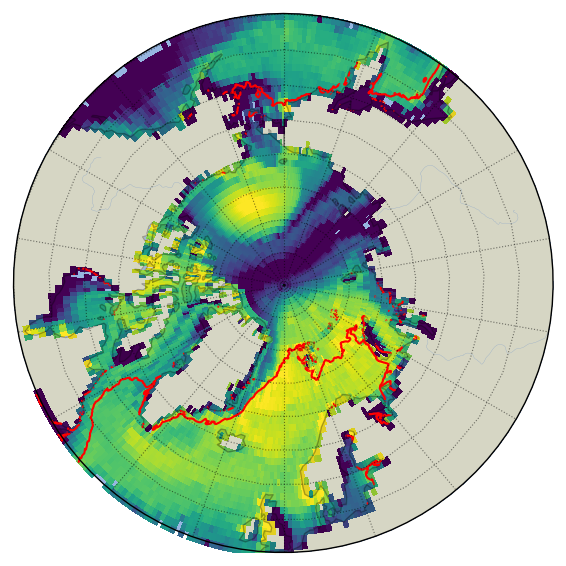

(14401, 14401)
winter_everywhere_res_10_extent_30_kernel_ice

3.3 s


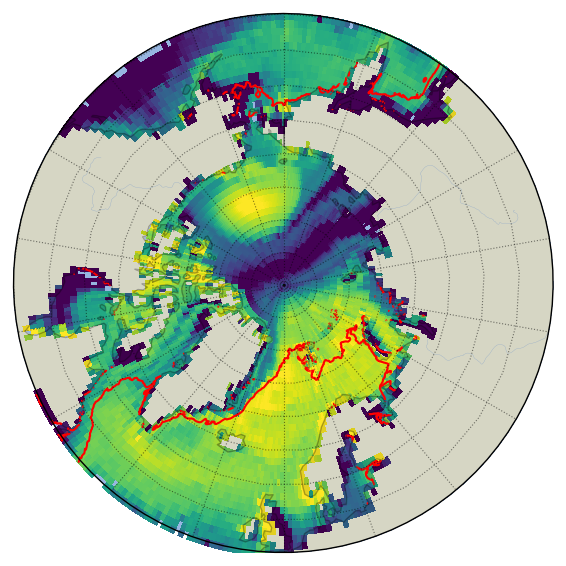

(14401, 14401)
winter_everywhere_res_10_extent_60_kernel_ice

2.9 s


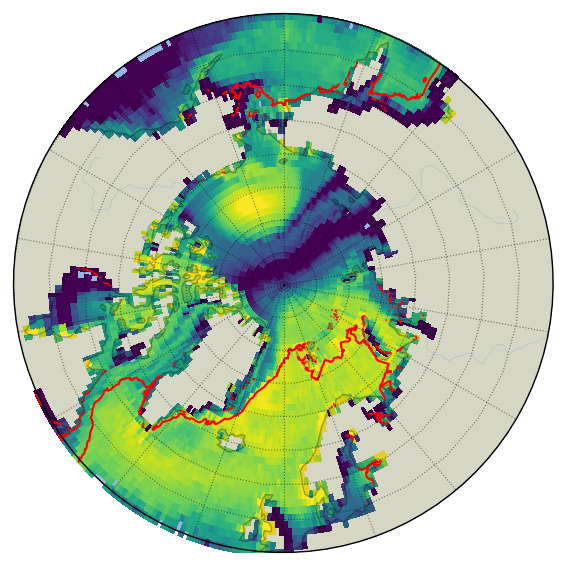

(14401, 14401)
winter_everywhere_res_10_extent_95_kernel_ice

3.4 s


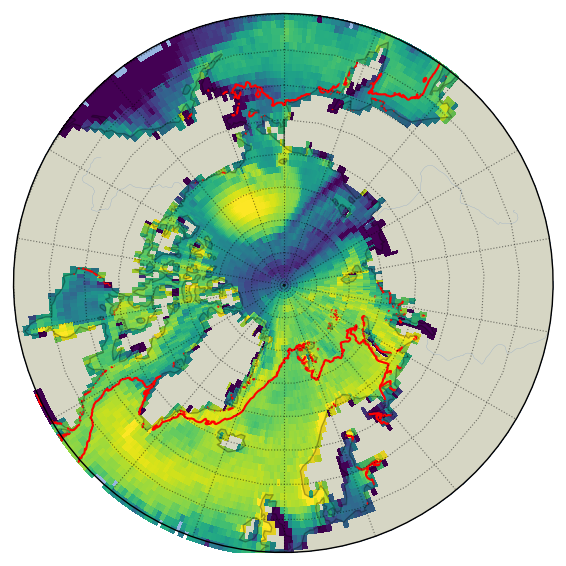

In [232]:
res = 1.0
year = 2015
simdays = 60
ts_everywhere = 2400
season = "winter"
kernel = "ice"
strait = "Everywhere"

Rs = []

for extent in [5, 30 , 60, 95]:
    custom = "extent{}".format(int(extent))
    T, M, lonbins, latbins  = load_transition_matrices(days=60, res=1.0, year = 2015, original = False, custom = custom)
    print np.shape(T)
    R  = make_plot(M,lonbins,latbins, season, res, extent, kernel, ts_everywhere, simdays, strait, year, save_it = True, add_cbar= False, returnstuff=True)
    Rs.append(R)
    plt.show()


## difference 5 and 95

In [233]:
R5    = Rs[0]
R95   = Rs[-1]
Rdiff = R95-R5

winter_everywhere_res_10_extent_95_kernel_ice


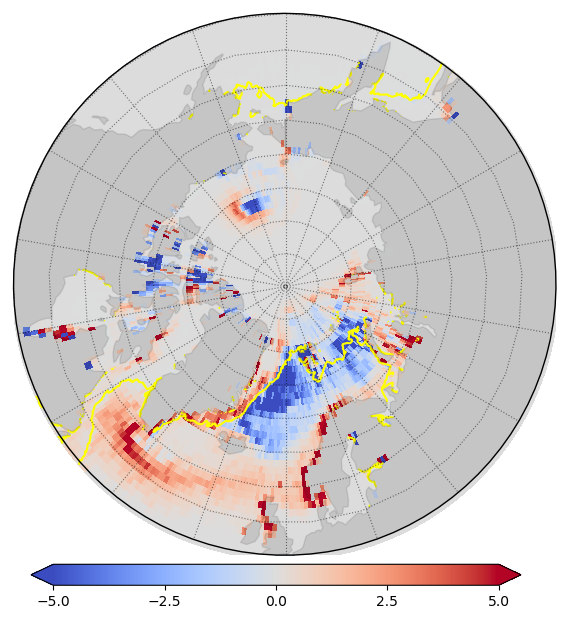

In [234]:
add_cbar = True


ax_width = 7
add_cbar = False
r,c      = transition_matrices.grid_subplots(1)   #nr of rows (r) and columns (c) in the grid
times    = times_calc(timespan, simdays)

'''Initialize figure'''
count    = 0
fig      = plt.figure(figsize = [c*ax_width, r*ax_width])
count   +=1
print("{}_everywhere_res_{}_extent_{}_kernel_{}".format(season, int(res*10), extent, kernel))

'''Set up axes'''
ax = fig.add_subplot(r, c, count, projection=ccrs.NorthPolarStereo())
ax = transition_matrices.set_subaxes(ax) 
ax.add_feature(cartopy.feature.LAND, facecolor = (0,0,0,.1), zorder = 2)
# ax.add_feature(cartopy.feature.OCEAN, facecolor = 'white',  zorder = 1)
# ax.coastlines()

'''Calculate and Plot the final distribution'''

nlat, nlon              = len(latbins)-1,len(lonbins)-1 
ncels                   = nlat*nlon
p                       = ax.pcolormesh(lonbins, latbins, Rdiff[:-1].reshape(nlat,nlon),  cmap = 'coolwarm', transform = ccrs.PlateCarree(),  vmin = -5, vmax = 5)

'''Extent'''
extentdate = datetime.strptime("{}-03-01".format(2015), "%Y-%m-%d").date()
plot_functions.plot_extent_contour(extentdate, ax, cmap = 'autumn_r')
ax.set_title("")  
plot_functions.set_circular_boundary(ax)

bottom_subplot = 0.10 / r
fig.subplots_adjust(bottom = bottom_subplot)
cbar_ax = fig.add_axes([0.15, 0.06, 0.7, bottom_subplot*.3])   #left, bottom, width , height
cbar = fig.colorbar(p, cax=cbar_ax, orientation = 'horizontal', extend = 'both')
cbar.set_ticks([-5,-2.5, 0, 2.5, 5])

plt.savefig(fig_dir + "sensitivity/difference_{}_everywhere_res_{}_extent_5_95_kernel_{}.png".format(season, int(res*10), extent, kernel), bbox_inches="tight", pad_inches=0.1)


# Function in the making
====================================================================================================

In [ ]:
def make_figure(custom, extent, season, kernel, year=2015,days=60,res=1, savefig=False,  add_cbar = False):
    

    ax_width = 7

    start = timer()



    vmax  = 10
    vmin  = 1e-6


    '''Make sure the grid looks nice''' 
    r,c = transition_matrices.grid_subplots(1)   #nr of rows (r) and columns (c) in the grid

    '''Initialize figure'''
    count = 0
    fig   = plt.figure(figsize = [c*ax_width, r*ax_width])
    fig.suptitle("")


    count+=1
    print("{}_everywhere_res_{}_extent_{}_kernel_{}".format(season, int(res*10), extent, kernel))

    times = times_calc(ts_everywhere, simdays)


    '''Set up axes'''
    ax = fig.add_subplot(r, c, count, projection=ccrs.NorthPolarStereo())
    ax = transition_matrices.set_subaxes(ax) 
    ax.add_feature(cartopy.feature.LAND, facecolor = (0,0,0,.1), edgecolor = (0,0,0,0.3), zorder = 1)

    '''Calculate and Plot the final distribution'''
    T, M, lonbins, latbins = load_transition_matrices(days=simdays, res=res, year=year)
    M       = load_npz(out_dir + "sensitivity/" + "M" + "_year_{}_simdays_{}_res_{}_{}".format(year,days, res, custom), M)


    R_full  = transition_matrices.final_R(M,latbins, lonbins, days = simdays, times=times, strait = strait, year=year)
    R       = R_full[-1,:]
    nlat, nlon = len(latbins)-1,len(lonbins)-1 
    ncels   = nlat*nlon
    p       = ax.pcolormesh(lonbins, latbins, R[0:ncels].reshape(nlat,nlon),   
                             norm = mpl.colors.LogNorm(vmin = vmin, vmax = vmax), 
                             cmap = 'viridis',
                             transform = ccrs.PlateCarree())

    '''Extent'''
    extentdate = datetime.strptime("{}-03-01".format(2015), "%Y-%m-%d").date()
    plot_functions.plot_extent_contour(extentdate, ax, cmap = 'autumn_r')
    ax.set_title("")  
    plot_functions.set_circular_boundary(ax)

    print("{:.1f} s".format(timer()-start))



    if add_cbar: 
        bottom_subplot = 0.10 / r
        fig.subplots_adjust(bottom = bottom_subplot)
        cbar_ax = fig.add_axes([0.15, 0.06, 0.7, bottom_subplot*.3])   #left, bottom, width , height
        cbar = fig.colorbar(p, cax=cbar_ax, orientation = 'horizontal', extend = 'max')

    if savefig: 
        plt.savefig(fig_dir + "sensitivity/{}_everywhere_res_{}_extent_{}_kernel_{}_.png".format(season, int(res), extent, kernel), 
                    bbox_inches="tight", pad_inches=0.1)


In [93]:





def trans_mat_digit_mfmf(ds_names, res, final_index =-1, in_ice = False, void = True, sink = True):
    '''
    Makes a transition matrix.
    ds_name = the name of the file (incl. direcotry)
    res     = resolution
    final_index in case you don't want it to be the last value
    ===============================================
    Returns Transition matrix, latbins, lonbins, sparse matrix
    '''
    
    ds = xr.open_mfdataset(ds_names, decode_times = False)

    N   = 360//res

    lons_i   = ds.lon.isel(obs= 0).values
    lats_i   = ds.lat.isel(obs= 0).values
    lons_f   = ds.lon.isel(obs= final_index).values
    lats_f   = ds.lat.isel(obs= final_index).values
    
    print("Opened dataset")
    
    nparts              = len(lons_i)
    particle_grid_index = np.zeros((2, nparts), dtype=int)
    ncels               = int ((360//res) * (40//res))

    if in_ice:
        in_ice_i = ds.in_ice.isel(obs=0).values  
        in_ice_f = ds.in_ice.isel(obs=final_index).values
        T        = np.zeros((ncels*2+1,ncels*2+1))
        
    else:
        in_ice_i = np.zeros(np.shape(lons_i))
        in_ice_f = np.zeros(np.shape(lons_i))
        T        = np.zeros((ncels+1,ncels+1))

    
    '''Find initial indices'''
    for i in range(nparts):
        if np.isnan(lons_i[i]) or np.isnan(lats_i[i]) :
            particle_grid_index[0,i] = -1
        else:
            particle_grid_index[0,i] = int((lats_i[i]-50)//res)*N  + int((lons_i[i]+ 180)//res) + int(in_ice_i[i]) * ncels

    '''Find final indices'''
    for i in range(nparts):
        if np.isnan(lons_f[i]) or np.isnan(lats_f[i]):
            particle_grid_index[1,i] = -1
        else:
            particle_grid_index[1,i] = int((lats_f[i]-50)//res)*N  + int((lons_f[i]+ 180)//res) + int(in_ice_f[i]) * ncels

    for i in range(nparts):
        T[particle_grid_index[1,i], particle_grid_index[0,i]] += 1

    
    print("Made transition matrix")
    '''Normalize matrix'''
    sumT =  np.sum(T, axis=0)
    sumT[sumT ==0] = 1
    T /=sumT

    '''Remove sinks'''
    if sink:
        max_sink = (np.diag(T)[:-1]).max()
        count    = 0
        while (max_sink == 1 and count <10):
            T        = transition_matrices.remove_sinks(T)
            count   += 1
            max_sink = (np.diag(T)[:-1]).max()
        print ("Count removal for sinks is {}" .format(count))

    T[:,-1]  = 0   # all nan's go to nan
    T[-1,-1] = 1

    
    
    if void: 
        zeros = np.where(T.sum(axis=0)==0)[0]
        Tkopy = T[:,:]
        Tkopy[zeros,:] = 0 
        sumTkopy =  np.sum(Tkopy, axis=0)
        sumTkopy[sumTkopy ==0] = 1.
        Tkopy = Tkopy/sumTkopy
        T = Tkopy[:,:]
        
    latbins, lonbins= np.arange(50,90+res, res),  np.arange(-180,180+res, res)          
    M_sparse = csr_matrix(T)
    print("Done with T")

    return T, latbins , lonbins, M_sparse
